In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Получаем датафрейм из файла csv

In [2]:
df = pd.read_csv("train.csv")
df

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,ExterQual,OpenPorchSF,Heating,Condition2,...,GarageCars,KitchenQual,KitchenAbvGr,GrLivArea,2ndFlrSF,CentralAir,BsmtQual,TotalBsmtSF,Fireplaces,SalePrice
0,Lvl,2003.0,2,856,706,8,Gd,61,GasA,Norm,...,2,Gd,1,1710,854,Y,Gd,856,0,208500
1,Lvl,1976.0,2,1262,978,6,TA,0,GasA,Norm,...,2,TA,1,1262,0,Y,Gd,1262,1,181500
2,Lvl,2001.0,2,920,486,6,Gd,42,GasA,Norm,...,2,Gd,1,1786,866,Y,Gd,920,1,223500
3,Lvl,1998.0,1,961,216,7,TA,35,GasA,Norm,...,3,Gd,1,1717,756,Y,TA,756,1,140000
4,Lvl,2000.0,2,1145,655,9,Gd,84,GasA,Norm,...,3,Gd,1,2198,1053,Y,Gd,1145,1,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Lvl,1999.0,2,953,0,7,TA,40,GasA,Norm,...,2,TA,1,1647,694,Y,Gd,953,1,175000
1456,Lvl,1978.0,2,2073,790,7,TA,0,GasA,Norm,...,2,TA,1,2073,0,Y,Gd,1542,2,210000
1457,Lvl,1941.0,2,1188,275,9,Ex,60,GasA,Norm,...,1,Gd,1,2340,1152,Y,TA,1152,2,266500
1458,Lvl,1950.0,1,1078,49,5,TA,0,GasA,Norm,...,1,Gd,1,1078,0,Y,TA,1078,0,142125


Далее необходимо проверить, есть ли поля с пустыми значениями

In [3]:
for col in df:
    print(col, df[col].isnull().sum())

LandContour 0
GarageYrBlt 81
FullBath 0
1stFlrSF 0
BsmtFinSF1 0
TotRmsAbvGrd 0
ExterQual 0
OpenPorchSF 0
Heating 0
Condition2 0
OverallQual 0
GarageCars 0
KitchenQual 0
KitchenAbvGr 0
GrLivArea 0
2ndFlrSF 0
CentralAir 0
BsmtQual 37
TotalBsmtSF 0
Fireplaces 0
SalePrice 0


Всего две колонки, которые содержат пустые значения.
81 и 37 по сравнению с 1460 записями малы, значит, их можно изменить на среднее значение, это не сильно повлияет на точность работы нашей будущей модели. Сначала необходимо кодировать категориальные строковые значения


In [4]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

categorised_columns = ['LandContour',
                       'ExterQual',
                       'Heating',
                       'Condition2',
                       'KitchenQual',
                       'CentralAir',
                       'BsmtQual']

for col in categorised_columns:
  df[col] = encoder.fit_transform(df[col])

Теперь меняем пустые значения на средние

In [5]:
nan_columns = ['GarageYrBlt', 'BsmtQual']
grouped = df.groupby(['LandContour'])
for col in nan_columns:
  mean_values = grouped.mean()
  df[col] = grouped[col].transform(lambda x: x.fillna(x.mean()))


Необходимо проверить, существует ли корреляция между различными столбцами.

<Axes: >

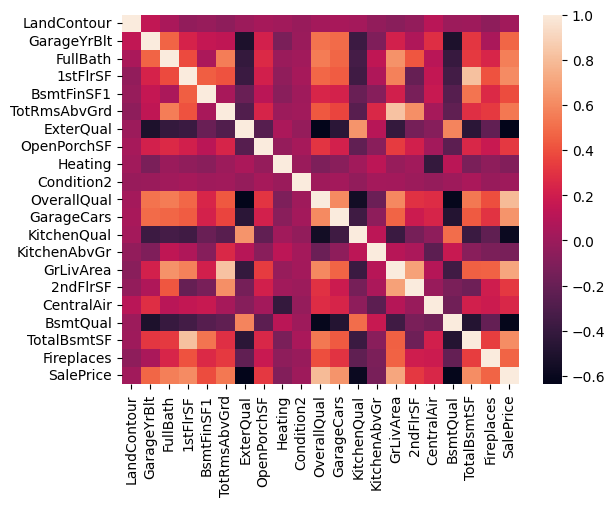

In [6]:
import seaborn as sns

sns.heatmap(df.corr())


На карте видно, что все столбцы, показывающие качество, так или иначе линейно зависимы с другими данными. Также можно заметить, что на цену не влияют ни тип отопления, ни контур участка

<Axes: >

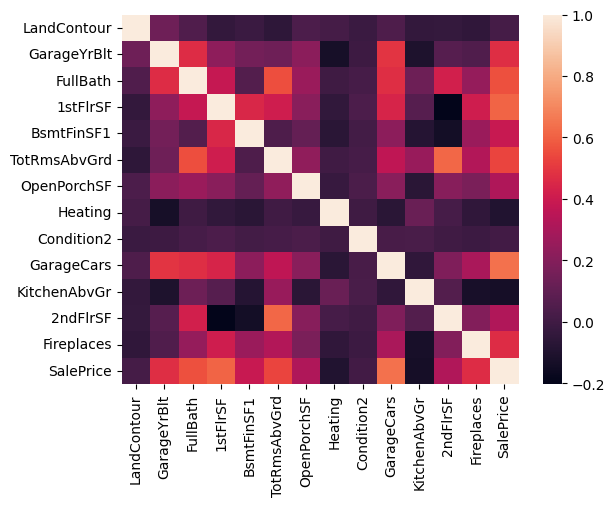

In [7]:
corr_columns = ['OverallQual', 'ExterQual', 'BsmtQual', 'KitchenQual', 'CentralAir', 'TotalBsmtSF', 'GrLivArea']

df = df.drop(corr_columns, axis=1)
sns.heatmap(df.corr())

Стоит убрать выбросы, которые повлияют на качество модели.

In [8]:
from sklearn.ensemble import IsolationForest


outliers = IsolationForest().fit_predict(df)
df['outlier'] = outliers
df = df.drop(df[df.outlier == -1].index)
df = df.drop('outlier', axis=1)
x_train = df.loc[:, df.columns != 'SalePrice']
df

,LandContour,GarageYrBlt,FullBath,1stFlrSF,BsmtFinSF1,TotRmsAbvGrd,OpenPorchSF,Heating,Condition2,GarageCars,KitchenAbvGr,2ndFlrSF,Fireplaces,SalePrice
0,3,2003.0,2,856,706,8,61,1,2,2,1,854,0,208500
1,3,1976.0,2,1262,978,6,0,1,2,2,1,0,1,181500
2,3,2001.0,2,920,486,6,42,1,2,2,1,866,1,223500
3,3,1998.0,1,961,216,7,35,1,2,3,1,756,1,140000
4,3,2000.0,2,1145,655,9,84,1,2,3,1,1053,1,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,1999.0,2,953,0,7,40,1,2,2,1,694,1,175000
1456,3,1978.0,2,2073,790,7,0,1,2,2,1,0,2,210000
1457,3,1941.0,2,1188,275,9,60,1,2,1,1,1152,2,266500
1458,3,1950.0,1,1078,49,5,0,1,2,1,1,0,0,142125


Далее необходимо проверить, нужна ли нормализация для данных. Это лучше всего сделать, просмотрев на распределение данных в датафрейме

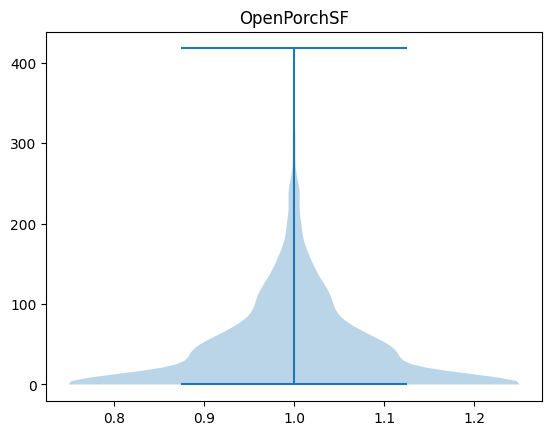

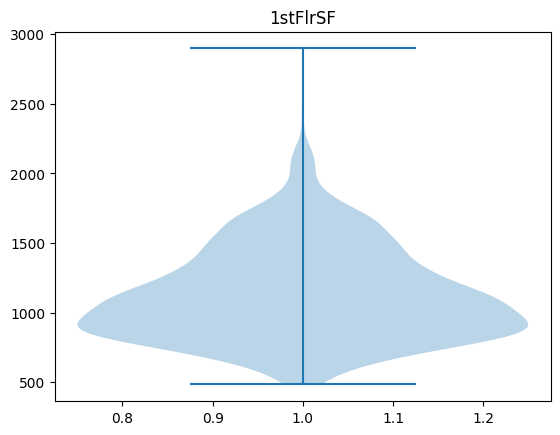

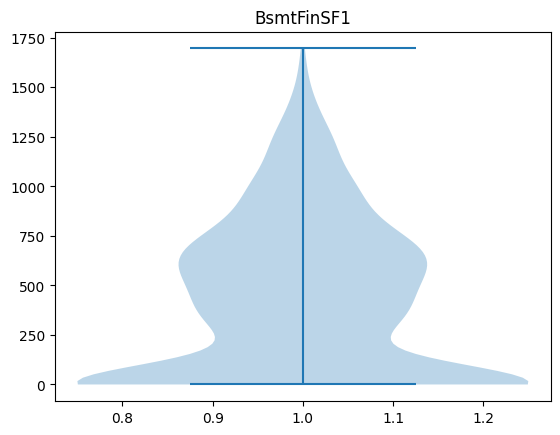

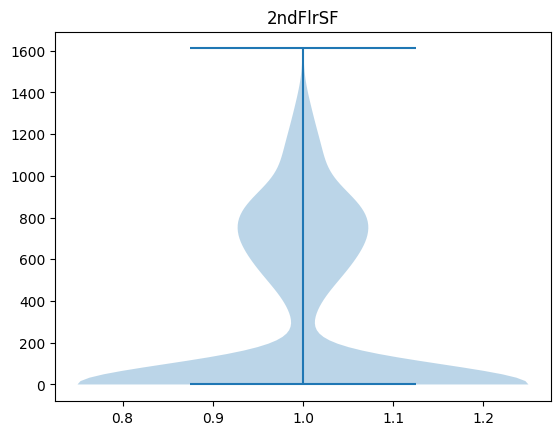

In [9]:
import matplotlib.pyplot as plt

normalizing_columns = [
    'OpenPorchSF',
    '1stFlrSF',
    'BsmtFinSF1',
    '2ndFlrSF',
]



for col in normalizing_columns:
  fig, ax = plt.subplots()
  ax.violinplot(x_train[col])
  ax.title.set_text(col)
plt.show()

Данные распределены нормально, теперь можно приступать к обучению модели

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x_train, df['SalePrice'])
print(x_train)

      LandContour  GarageYrBlt  FullBath  1stFlrSF  BsmtFinSF1  TotRmsAbvGrd  \
0               3       2003.0         2       856         706             8   
1               3       1976.0         2      1262         978             6   
2               3       2001.0         2       920         486             6   
3               3       1998.0         1       961         216             7   
4               3       2000.0         2      1145         655             9   
...           ...          ...       ...       ...         ...           ...   
1455            3       1999.0         2       953           0             7   
1456            3       1978.0         2      2073         790             7   
1457            3       1941.0         2      1188         275             9   
1458            3       1950.0         1      1078          49             5   
1459            3       1965.0         1      1256         830             6   

      OpenPorchSF  Heating  Condition2 

In [11]:
coef = pd.DataFrame(zip(['intercept']+x_train.columns.tolist(), [model.intercept_]+model.coef_), columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,-1.254945e+06
1,LandContour,-1.253174e+06
2,GarageYrBlt,-1.251840e+06
3,FullBath,-1.253721e+06
4,1stFlrSF,-1.253794e+06
5,BsmtFinSF1,-1.253433e+06
6,TotRmsAbvGrd,-1.253768e+06
7,OpenPorchSF,-1.261822e+06
8,Heating,-1.238403e+06
9,Condition2,-1.236833e+06


In [12]:
model.score(x_train, df['SalePrice'])

0.7915492893558669

In [13]:
test_x = pd.read_csv("test.csv")

for col in categorised_columns:
  test_x[col] = encoder.fit_transform(test_x[col])

nan_columns = ['GarageYrBlt', 'BsmtFinSF1', 'GarageCars', 'KitchenQual', 'BsmtQual', 'TotalBsmtSF']
grouped = test_x.groupby(['LandContour'])
for col in nan_columns:
  mean_values = grouped.mean()
  test_x[col] = grouped[col].transform(lambda x: x.fillna(x.mean()))

test_x = test_x.drop(corr_columns, axis=1)

In [14]:
predicted_cost = model.predict(test_x)
actual_cost = pd.read_csv('sample_submission.csv')

from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_cost['SalePrice'], predicted_cost))


4047361989.437816
